In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


def asimov_sig(s, b) -> float:
    """Median expected significance for a counting experiment, valid in the asymptotic regime.
    Also valid for the multi-bin case.

    Parameters
    ----------
    s : Array
        Signal counts.
    b : Array
        Background counts.

    Returns
    -------
    float
        The expected significance.
    """
    # Convert s and b to numpy arrays to handle element-wise operations
    s = np.asarray(s)
    b = np.asarray(b)

    # Prevent division by zero and log of zero, and ignpres b=0
    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = np.where(b > 0, s / b, 0)
        term = np.where(b > 0, (s + b) * np.log1p(ratio) - s, 0)

    q0 = 2 * np.sum(term)
    return q0**0.5



run2_file = "/lustre/fs22/group/atlas/freder/hh/run/dump/determine_asimov_cuts_bce_10k_best/dump-run2.h5"
signal_file = "/lustre/fs22/group/atlas/freder/hh/run/dump/determine_asimov_cuts_bce_10k_best/dump-l1cvv0cv1.h5"


1012012.012012012
4.864864864864865
18018.018018018018
0.0


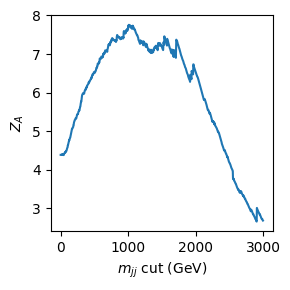

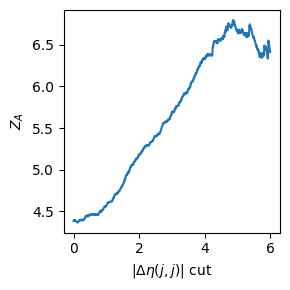

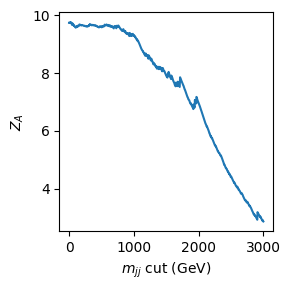

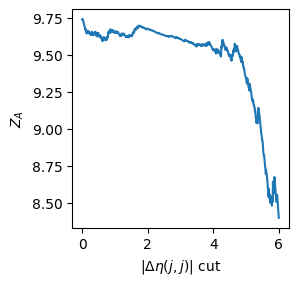

In [2]:

vars = [
    "m_hh_5",
    "tomatos_bce_5_10000_lr_0p0005",
    # "tomatos_cls_5_3000_lr_0p0001_bw_opt_0p01_bkg_protect_0p1_vr_protect_2_slope_1k_amplify_bkg_shape_6",
]


# vars = [
#     # "m_jj",
#     "eta_jj",
# ]
cut_vars = [
    "m_jj",
    "eta_jj",
]


with h5py.File(run2_file, "r") as run2:
    with h5py.File(signal_file, "r") as signal:
        for var in vars:
            for cut_var in cut_vars:

                # print(signal[f"{var}_NOSYS.SR_xbb_2"][signal[f"{cut_var}_NOSYS.SR_xbb_2"][:]<11e3].shape)
                sig = []
                if cut_var == "m_jj":
                    cuts = np.linspace(0, 3e6, 1000)
                    label = r"$m_{jj}$ cut (GeV)"
                if cut_var == "eta_jj":
                    cuts = np.linspace(0, 6, 1000)
                    label = r"$|\Delta\eta(j,j)|$ cut"
                bins = np.linspace(0, 1, 20)
                # bins = [0.0, 0.0062, 0.1651, 0.7219, 0.9387, 1.0]
                # bins = [0.0, 0.2563, 0.5875, 0.8023, 0.9323, 1.0]
                if "m_hh" in var:
                    bins = np.linspace(500_000, 5_000_000, 20)
                    # bins = [
                    #     500000.0,
                    #     1038400.0,
                    #     1228200.0,
                    #     1468000.0,
                    #     1842800.0,
                    #     5000000.0,
                    # ]
                    # bins = [
                    #     500000.0,
                    #     978000.0,
                    #     1163600.0,
                    #     1382800.0,
                    #     1692400.0,
                    #     5000000.0,
                    # ]

                for c in cuts:
                    sel_signal = signal[f"{var}_NOSYS.SR_xbb_2"][
                        signal[f"{cut_var}_NOSYS.SR_xbb_2"] > c
                    ]

                    sel_run2 = run2[f"{var}_NOSYS.SR_xbb_1"][
                        run2[f"{cut_var}_NOSYS.SR_xbb_1"] > c
                    ]
                    sel_run2_VR = run2[f"{var}_NOSYS.VR_xbb_1"][
                        run2[f"{cut_var}_NOSYS.VR_xbb_1"] > c
                    ]
                    run2_vr_xbb_2 = run2[f"{var}_NOSYS.VR_xbb_2"][
                        run2[f"{cut_var}_NOSYS.VR_xbb_2"] > c
                    ]

                    signal_hist = np.histogram(
                        sel_signal,
                        weights=signal["weights_NOSYS.SR_xbb_2"][
                            signal[f"{cut_var}_NOSYS.SR_xbb_2"] > c
                        ],
                        bins=bins,
                    )[0]

                    bkg_CR_xbb_2 = np.sum(
                        run2[f"{var}_NOSYS.CR_xbb_2"][
                            run2[f"{cut_var}_NOSYS.CR_xbb_2"] > c
                        ]
                    )
                    bkg_CR_xbb_1 = np.sum(
                        run2[f"{var}_NOSYS.CR_xbb_1"][
                            run2[f"{cut_var}_NOSYS.CR_xbb_1"] > c
                        ]
                    )
                    w_CR = bkg_CR_xbb_2 / bkg_CR_xbb_1
                    run2_hist = np.histogram(sel_run2, bins=bins)[0] * w_CR
                    # run2_VR_hist = np.histogram(sel_run2_VR, bins=bins)[0] * w_CR
                    run2_vr_xbb_2_hist = np.histogram(run2_vr_xbb_2, bins)[0]
                    # bkg_unc_ratio = np.abs(
                    #     (run2_VR_hist - run2_vr_xbb_2_hist) / run2_VR_hist
                    # )

                    # if not all(
                    #     (run2_hist > 1)
                    #     # & (bkg_unc_ratio < 1)
                    #     # & (run2_vr_xbb_2_hist >= 1)
                    # ):
                    #     sig += [np.nan]
                    #     continue
                    # if np.sum(run2_hist) < 5:
                    #     sig += [np.nan]
                    #     continue
                    sig += [asimov_sig(signal_hist, run2_hist)]

                plt.figure(figsize=(3, 3))
                if "m_jj" in cut_var:
                    plt.plot(cuts * 1e-3, sig)
                else:
                    plt.plot(cuts, sig)

                ax = plt.gca()

                sig = np.array(sig)
                # replace nans otherwise argmax not working
                sig[np.isnan(sig)] = -1.0

                print(cuts[np.argmax(sig)])

                # ax.set_yscale("log")
                plt.ylabel(r"$Z_A$")
                plt.xlabel(label)
                plt.tight_layout()
                plt.savefig(
                    "/lustre/fs22/group/atlas/freder/hh/run/plots/s_b_optimization/"
                    + "s_b_optimization_"
                    + var
                    + "_"
                    + cut_var
                    + ".pdf"
                )

9.748456484482587
34.74292
83.77271057613518


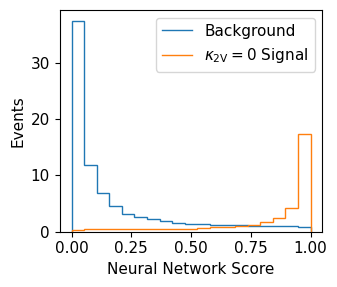

In [3]:
with h5py.File(run2_file, "r") as bkg:
    with h5py.File(signal_file, "r") as sig:
        vbf_cut = 1012012.012012012
        eta_cut = 4.864864864864865

        # vbf_cut = 1000e3
        # eta_cut = 4.5

        vbf_cut = 0.0
        eta_cut = 0.0

        # vbf_cut = 288288.2882882883
        # eta_cut = 2.960960960960961

        # vbf_cut = 250e3
        # eta_cut = 3

        bins = np.linspace(500_000, 5_000_000, 20)
        bins = np.linspace(0, 1, 20)
        var = "m_hh_5"
        var = "tomatos_bce_5_10000_lr_0p0005"

        bkg_CR_xbb_2 = len(
            bkg[f"{var}_NOSYS.CR_xbb_2"][
                (bkg[f"m_jj_NOSYS.CR_xbb_2"][:] > vbf_cut)
                & (bkg[f"eta_jj_NOSYS.CR_xbb_2"][:] > eta_cut)
            ]
        )

        bkg_CR_xbb_1 = len(
            bkg[f"{var}_NOSYS.CR_xbb_1"][
                (bkg[f"m_jj_NOSYS.CR_xbb_1"][:] > vbf_cut)
                & (bkg[f"eta_jj_NOSYS.CR_xbb_1"][:] > eta_cut)
            ]
        )
        w_CR = bkg_CR_xbb_2 / bkg_CR_xbb_1

        s_selection = (sig[f"m_jj_NOSYS.SR_xbb_2"][:] > vbf_cut) & (
            sig[f"eta_jj_NOSYS.SR_xbb_2"][:] > eta_cut
        )
        b_selection = (bkg[f"m_jj_NOSYS.SR_xbb_1"][:] > vbf_cut) & (
            bkg[f"eta_jj_NOSYS.SR_xbb_1"][:] > eta_cut
        )
        s_hist = np.histogram(
            sig[f"{var}_NOSYS.SR_xbb_2"][s_selection],
            bins=bins,
            weights=sig[f"weights_NOSYS.SR_xbb_2"][s_selection],
        )[0]
        b_hist = (
            np.histogram(
                bkg[f"{var}_NOSYS.SR_xbb_1"][b_selection],
                bins,
            )[0]
            * w_CR
        )
        print(asimov_sig(s_hist, b_hist))
        print(np.sum(s_hist))
        print(np.sum(b_hist))

        if var == "m_hh_5":
            bins = np.array(bins) * 1e-3

        plt.rcParams.update({"font.size": 11})
        plt.figure(figsize=(3.5, 3))
        plt.stairs(b_hist, bins, label="Background")
        plt.stairs(s_hist, bins, label=r"$\kappa_\mathrm{2V}=0$ Signal")

        if var == "m_hh_5":
            plt.xlabel(r"$m_\mathrm{HH}$ (GeV)")
        else:
            plt.xlabel("Neural Network Score")

        # plt.text(
        #     0.95,
        #     0.5,
        #     rf"Total bkg={np.round(np.sum(b_hist),2)}",
        #     transform=plt.gca().transAxes,
        #     verticalalignment="center",
        #     horizontalalignment="right",
        #     color="tab:blue",
        # )
        plt.ylabel("Events")
        plt.legend()
        plt.tight_layout()
        plt.savefig(
            f"/lustre/fs22/group/atlas/freder/hh/run/plots/s_b_optimization/{var}_s_b_{vbf_cut}.pdf"
        )

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

run2_file = (
    "/lustre/fs22/group/atlas/freder/hh/run/dump/determine_asimov_cuts/dump-run2.h5"
)
signal_file = "/lustre/fs22/group/atlas/freder/hh/run/dump/determine_asimov_cuts/dump-l1cvv0cv1.h5"

plt.figure(figsize=(5, 3.5))
with h5py.File(run2_file, "r") as run2:
    with h5py.File(signal_file, "r") as signal:
        # Calculate correlation coefficient for reference
        print(
            np.corrcoef(
                np.array(
                    [
                        # run2["m_jj_NOSYS.SR_xbb_1"][:],
                        # run2["eta_jj_NOSYS.SR_xbb_1"][:],
                        signal["m_jj_NOSYS.SR_xbb_1"][:],
                        signal["eta_jj_NOSYS.SR_xbb_1"][:],
                    ]
                )
            )
        )

        # Create 2D histogram
        plt.hist2d(
            run2["m_jj_NOSYS.SR_xbb_1"][:] * 1e-3,  # m_jj converted to TeV
            run2["eta_jj_NOSYS.SR_xbb_1"][:],
            # signal["m_jj_NOSYS.SR_xbb_2"][:] * 1e-3,  # m_jj converted to TeV
            # signal["eta_jj_NOSYS.SR_xbb_2"][:],
            bins=(100, 100),  # Adjust bins as needed
            cmap="viridis",  # Choose a color map, e.g., 'viridis'
            norm=mcolors.LogNorm(),  # Apply logarithmic scaling
        )

plt.colorbar(label="Counts")
plt.rcParams.update({"font.size": 14})
plt.ylabel(r"$|\Delta\eta(j,j)|$")
plt.xlabel(r"$m_{jj}$ (GeV)")
plt.grid()
# plt.xlim([0, 5000])
# # # Customize x-ticks with rounded values
# # x_min, x_max = plt.gca().get_xlim()
# # x_ticks = np.arange(
# #     np.floor(x_min), np.ceil(x_max), step=500
# # )  # Set step size for more readable ticks
# # plt.xticks(x_ticks,rotation=20)
# ax = plt.gca()
# ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
# plt.xticks(rotation=90)




plt.xlim([0, 5000])

# Customize x-ticks with major and minor locators
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(250))  # Minor ticks for a finer grid
plt.xticks(rotation=90)

# Enable grid for both major and minor ticks on both axes
plt.grid(which='both', linewidth=0.5)
plt.tight_layout()
plt.text(0.6,0.1,"")
# plt.savefig(
#     "/lustre/fs22/group/atlas/freder/hh/run/plots/s_b_optimization/vbf_correlation_2d_hist_signal.pdf"
# )

plt.savefig(
    "/lustre/fs22/group/atlas/freder/hh/run/plots/s_b_optimization/vbf_correlation_2d_hist_bkg.pdf"
)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/lustre/fs22/group/atlas/freder/hh/run/dump/determine_asimov_cuts/dump-run2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

<Figure size 500x350 with 0 Axes>